Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [38]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

random_state = 1

In [39]:
digits = load_digits()
X = digits['data']
y = digits['target']

assert X.shape == (1797, 64), y.shape == (1797,)

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

In [40]:
digits.images = abs(digits.images - 16)

<Figure size 432x288 with 0 Axes>

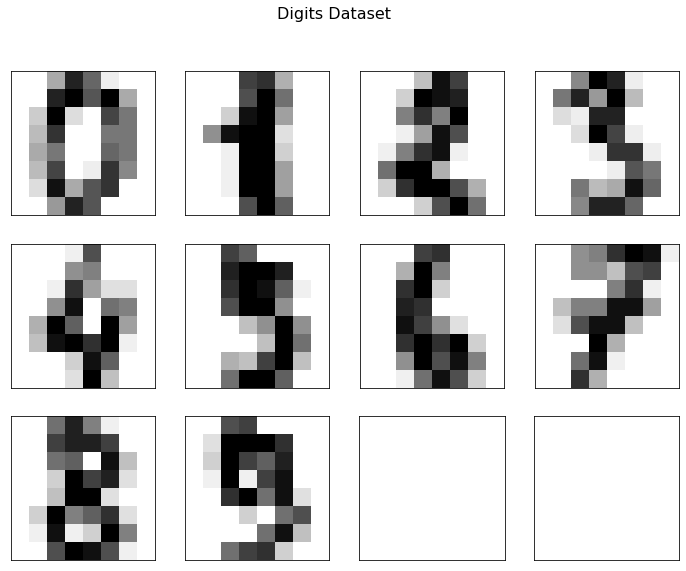

In [41]:
plt.gray()

fig, axs = plt.subplots(3, 4)

fig.set_figheight(9)
fig.set_figwidth(12)
fig.suptitle('Digits Dataset', fontsize=16)

for i in range(3):
    for j in range(4):
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        n = i*4 + j
        if n < 10:
            axs[i, j].imshow(X=digits.images[n], interpolation='none');

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [42]:
n_clusters = 10
n_rows = X.shape[0]

In [43]:
aggc = AgglomerativeClustering(n_clusters=n_clusters)

aggc.fit_predict(X)

assert aggc.labels_.shape[0] == n_rows

aggc_labels = aggc.labels_

In [44]:
kmeans = KMeans(n_clusters=n_clusters, n_init=100)

kmeans.fit_predict(X)

assert kmeans.labels_.shape[0] == n_rows

kmeans_labels = kmeans.labels_

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [45]:
def plot_digits(labels, clustering_type):
    plt.gray()
    fig, axs = plt.subplots(3, 4)
    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle(f'Cluster Centers after {clustering_type} Clustering', fontsize=16)

    for n in range(3):
        for m in range(4):
            axs[n, m].set_xticks([])
            axs[n, m].set_yticks([])
            i = n*4 + m
            if i < 10:
                mask = (labels == i)
                cluster_center = np.mean(a=digits.images[mask, :, :], axis=0)
                axs[n, m].imshow(X=cluster_center, interpolation='none');

<Figure size 432x288 with 0 Axes>

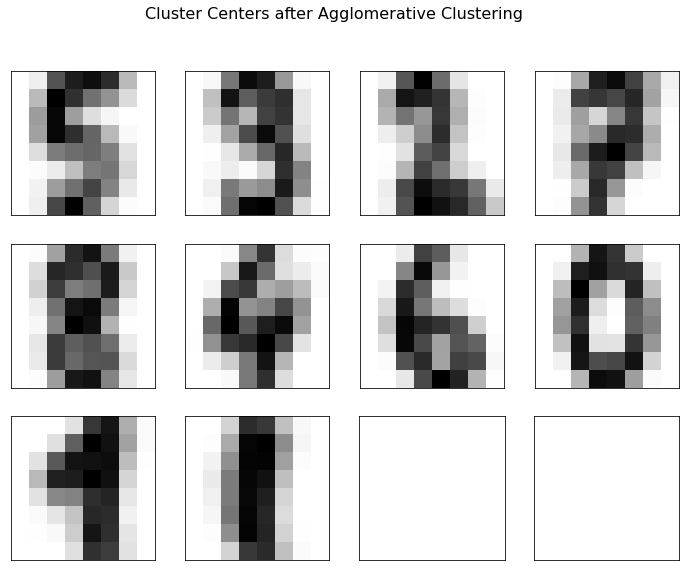

In [46]:
plot_digits(labels=aggc_labels, clustering_type='Agglomerative')

<Figure size 432x288 with 0 Axes>

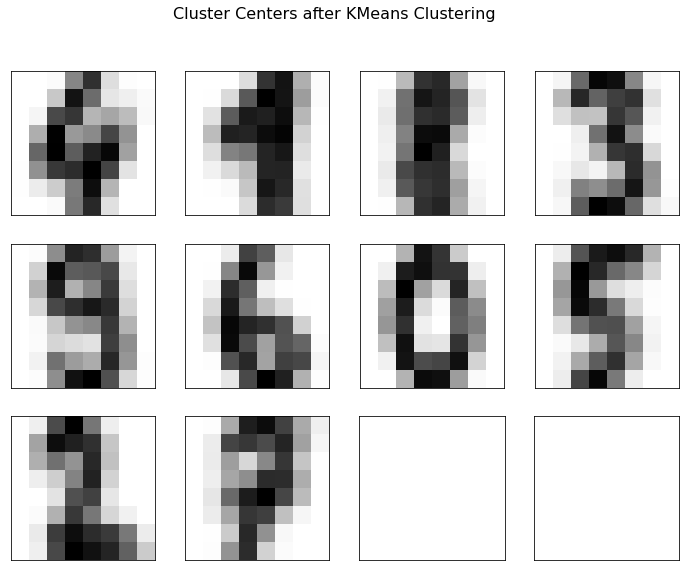

In [47]:
plot_digits(labels=kmeans_labels, clustering_type='KMeans')

Как видно, центры кластеров в обоих случаях представляют собой не очень чёткие представления цифр, однако в случае KMeans некоторые из изображений значительно лучше различимы. На визуализации центров кластеров после иерархической кластеризации трудно отличить друг от друга 3, 8 и 9, чего нельзя сказать о KMeans: зрительно понятно, какой центр представляет собой какую из цифр.

------

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [48]:
K = list(range(2, 21))

In [49]:
def get_labels(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=random_state)
    kmeans.fit_predict(X)
    kmeans_labels = kmeans.labels_
    
    aggc = AgglomerativeClustering(n_clusters=n_clusters)
    aggc.fit_predict(X)
    aggc_labels = aggc.labels_
    
    return kmeans_labels, aggc_labels

In [50]:
def get_scores(X, kmeans_labels, aggc_labels, y_true=0, scoring='silhouette'):

    if scoring == 'silhouette':
        kmeans_sc = silhouette_score(X=X, labels=kmeans_labels)
        aggc_sc = silhouette_score(X=X, labels=aggc_labels)
        
    elif scoring == 'v-measure':
        h, c, v_measure = homogeneity_completeness_v_measure(labels_true=y_true, labels_pred=kmeans_labels)
        kmeans_sc = v_measure
        h, c, v_measure = homogeneity_completeness_v_measure(labels_true=y_true, labels_pred=aggc_labels)
        aggc_sc = v_measure  
        
    return kmeans_sc, aggc_sc

In [51]:
def predict_and_score(X, y_true=0, scoring='silhouette'):
    kmeans_scores, aggc_scores  = [], []
    for k in K:
        kmeans_labels, aggc_labels = get_labels(X, k)
        kmeans_sc, aggc_sc = get_scores(X, kmeans_labels, aggc_labels, y_true, scoring)
        kmeans_scores.append(kmeans_sc)
        aggc_scores.append(aggc_sc)
            
    return kmeans_scores, aggc_scores    

In [52]:
def visualize_scores(kmeans_scores, aggc_scores, K, supt, x_lab, y_lab):
    plt.plot(K, kmeans_scores)
    plt.plot(K, aggc_scores)
    plt.suptitle(supt)
    plt.legend(['KMeans', 'Agglomerative Clustering'])
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.xticks(K, K)
    plt.grid()

    plt.show()

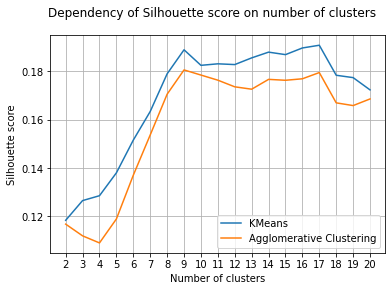

In [53]:
kmeans_sil, aggc_sil =  predict_and_score(X)

visualize_scores(kmeans_sil, aggc_sil, K, 
                 'Dependency of Silhouette score on number of clusters',
                 'Number of clusters', 'Silhouette score')

In [54]:
raw_sil_kmeans_max, raw_sil_aggc_max = max(kmeans_sil), max(aggc_sil)

print('---Silhouette score on raw data---\n')
print(f'Max for KMeans:\n{raw_sil_kmeans_max}')
print(f'Max for Agglomerative Clustering:\n{raw_sil_aggc_max}')

---Silhouette score on raw data---

Max for KMeans:
0.19084737771625154
Max for Agglomerative Clustering:
0.18061975703867697


Для обоих методов кластеризации максимальное значение силуэта наблюдается при разбиении данных на 9 кластеров.

---

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

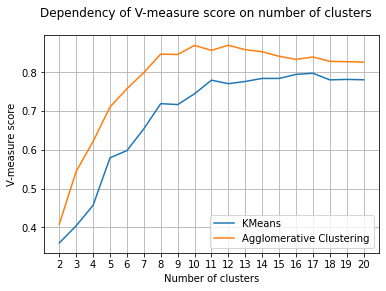

In [55]:
kmeans_v, aggc_v =  predict_and_score(X, y, scoring='v-measure')

visualize_scores(kmeans_v, aggc_v, K, 
                 'Dependency of V-measure score on number of clusters',
                 'Number of clusters', 'V-measure score')

In [56]:
raw_v_kmeans_max, raw_v_aggc_max = max(kmeans_v), max(aggc_v)

print('---V-measure score on raw data---\n')
print(f'Max for KMeans:\n{raw_v_kmeans_max}')
print(f'Max for Agglomerative Clustering:\n{raw_v_aggc_max}')

---V-measure score on raw data---

Max for KMeans:
0.796482408635699
Max for Agglomerative Clustering:
0.86854875186737


Максимум V-меры достигается при 10 и 12ти кластерах для Иерархической кластеризации и при 18ти кластерах - для KMeans.


P.S. На самом деле, как в случае силуэта, так и в случае v-меры, максимизирующие их число кластеров может быть различным в зависимости от параметра random_state в KMeans.

---

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [57]:
def silhouette_and_v_measure(X_reduced, y_true, kmeans_sil_list, aggc_sil_list, kmeans_v_list, aggc_v_list, n_clusters=10):
    kmeans_labels, aggc_labels = get_labels(X_reduced, n_clusters)
    
    kmeans_si, aggc_si = get_scores(X_reduced, kmeans_labels, aggc_labels, y_true=0, scoring='silhouette')    
    kmeans_v, aggc_v = get_scores(X_reduced, kmeans_labels, aggc_labels, y_true=y_true, scoring='v-measure')
    
    kmeans_sil_list.append(kmeans_si)
    aggc_sil_list.append(aggc_si)    
    kmeans_v_list.append(kmeans_v)
    aggc_v_list.append(aggc_v)

In [58]:
def compare_with_raw(km_s, ag_s, km_v, ag_v, km_s_raw=raw_sil_kmeans_max, 
                     ag_s_raw=raw_sil_kmeans_max,  km_v_raw=raw_sil_kmeans_max,  ag_v_raw=raw_sil_kmeans_max,
                     data_type='TruncatedSVD'):
    print(f'\n---Silhouette score on {data_type} data---\n')
    print(f'KMeans:\n{max(km_s)} (was {km_s_raw} on raw data)')
    print(f'Agglomerative Clustering:\n{max(ag_s)} (was {ag_s_raw} on raw data)')
    print(f'\n---V-measure score on {data_type} data---\n')
    print(f'KMeans:\n{max(km_v)} (was {km_v_raw} on raw data)')
    print(f'Agglomerative Clustering:\n{max(ag_v)} (was {ag_v_raw} on raw data)')

In [59]:
N = [2, 5, 10, 20]
n_clusters = 10

kmeans_reduced_sil, aggc_reduced_sil, kmeans_reduced_v, aggc_reduced_v = [], [], [], []

In [60]:
for n in N:
    svd = TruncatedSVD(n_components=n)
    X_reduced = svd.fit_transform(X)
    silhouette_and_v_measure(X_reduced, y, kmeans_reduced_sil, aggc_reduced_sil, kmeans_reduced_v, aggc_reduced_v)

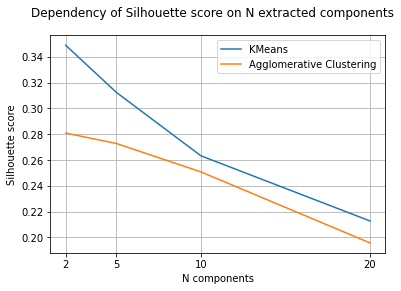

In [61]:
visualize_scores(kmeans_reduced_sil, aggc_reduced_sil, N,
                 'Dependency of Silhouette score on N extracted components',
                 'N components', 'Silhouette score')

Как видно на верхнем графике, с уменьшением числа извлекаемых фич значение силуэта значительно растёт. В целом, это логично: при понижении размерности пространства с помощью SVD производятся линейные преобразования, и расстояния между наблюдениями искажаются. В соответствии со значениями силуэта нам следовало бы оставить всего две фичи.

Однако для выбора итогового числа фич надо ориентироваться и на V-меру: как видно на графике снизу, если мы остановимся на двух фичах, то сильно проиграем. Алгоритм будет очень часто ошибаться и выделять неверные кластеры. 

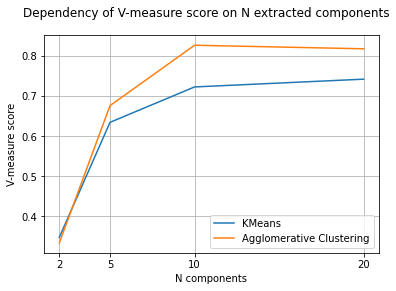

In [62]:
visualize_scores(kmeans_reduced_v, aggc_reduced_v, N,
                 'Dependency of V-measure score on N extracted components',
                 'N components', 'V-measure score')

При этом надо отметить, что значения силуэта растут с уменьшением выделенных фич, и превосходят результаты, полученные на исходных данных. Однако того же нельзя сказать о значениях V-меры: даже наибольшее из них на извлечённых фичах не превосходит максимального значения, полученного нами ранее на исходных данных. 

In [63]:
compare_with_raw(kmeans_reduced_sil, aggc_reduced_sil, kmeans_reduced_v, aggc_reduced_v, data_type='TruncatedSVD')


---Silhouette score on TruncatedSVD data---

KMeans:
0.34889617904204717 (was 0.19084737771625154 on raw data)
Agglomerative Clustering:
0.280816785100888 (was 0.19084737771625154 on raw data)

---V-measure score on TruncatedSVD data---

KMeans:
0.7414911475367869 (was 0.19084737771625154 on raw data)
Agglomerative Clustering:
0.8259753348813222 (was 0.19084737771625154 on raw data)


---

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [64]:
tsne = TSNE(random_state=random_state)
X_reduced = tsne.fit_transform(X)

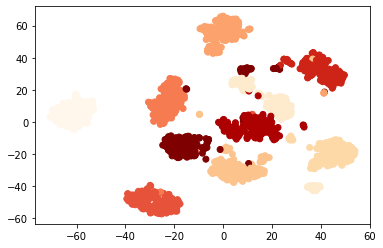

In [65]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='OrRd');

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [66]:
kmeans_reduced_sil, aggc_reduced_sil, kmeans_reduced_v, aggc_reduced_v = [], [], [], []

In [67]:
silhouette_and_v_measure(X_reduced, y, 
                         kmeans_reduced_sil, aggc_reduced_sil, kmeans_reduced_v, aggc_reduced_v)

In [68]:
compare_with_raw(kmeans_reduced_sil, aggc_reduced_sil, kmeans_reduced_v, aggc_reduced_v, data_type='t-SNE`d')


---Silhouette score on t-SNE`d data---

KMeans:
0.6278941631317139 (was 0.19084737771625154 on raw data)
Agglomerative Clustering:
0.6287780404090881 (was 0.19084737771625154 on raw data)

---V-measure score on t-SNE`d data---

KMeans:
0.8987481589531523 (was 0.19084737771625154 on raw data)
Agglomerative Clustering:
0.8921775702744312 (was 0.19084737771625154 on raw data)


Как видно, после применения t-SNE значительно улучшился как силуэт, так и v-мера.

---

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

<Figure size 432x288 with 0 Axes>

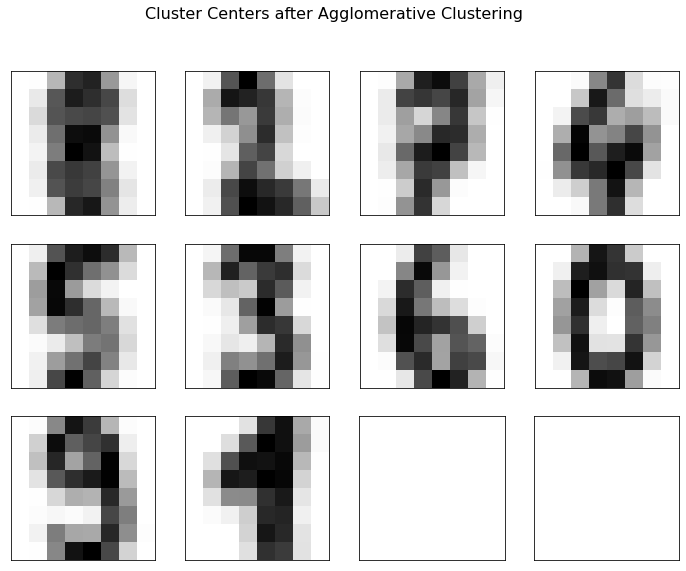

In [69]:
aggc = AgglomerativeClustering(n_clusters=10)
aggc.fit_predict(X_reduced)

plot_digits(labels=aggc.labels_, clustering_type='Agglomerative');

Лучшее разбиение в терминах как силуэта, так и v-меры было произведено иерархической кластеризацией, так что визуализированы центры этого разбиения. Теперь кластеры не выглядят двусмысленно, а вполне определённо соответствуют нужным цифрам, особенно по сравнению с результатом того же метода кластеризации на исходных данных.

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

1) Если ориентироваться на визуализацию центров кластеров, то KMeans превосходит иерархическую кластеризацию и уже на сырых данных практически не имел двусмысленности в прочтении. Конечно, это также зависит от настроек: в зависимости от заданного числа кластеров (и random_state - для KMeans) алгоритмы могут справляться хуже или лучше. Значение силуэта для KMeans обычно лучше, а v-мера, наоборот, хуже, чем при иерархической кластеризации; так что можно сказать, что от избранного критерия оценивания скорее всего будет зависеть, какой метод кластеризации в итоге будет выбран.

2) Зависит от выбранного метода снижения размерности. При использовании TruncatedSVD улучшился силуэт, но ухудшилась v-мера, т.е. "точность" кластеризации пострадала. Однако после применения t-SNE улучшился и силуэт, и v-мера, причём достаточно значительно. Более того, визуальное отображение центров потеряло двусмысленность. 

---

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](https://stackoverflow.com/a/60450028). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [70]:
from sklearn.datasets import fetch_openml
df, target = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
#строка ниже не нравится google colab`у, но в jupyter notebook с ней всё ок

df, target = df.to_numpy(), target.to_numpy()

In [71]:
def sil_and_v_for_kmeans(df, target=target, n_clusters=10):

    mbkmeans = MiniBatchKMeans(n_clusters=n_clusters)
    mbkmeans.fit_predict(df)
    mbkmeans_labels = mbkmeans.labels_

    mbkmeans_sil = silhouette_score(X=df, labels=mbkmeans_labels)

    h, c, v_measure = homogeneity_completeness_v_measure(labels_true=target, labels_pred=mbkmeans_labels)
    mbkmeans_v = v_measure 

    print(f'Silhouette score: {mbkmeans_sil}\nV-measure: {mbkmeans_v}')

In [72]:
sil_and_v_for_kmeans(df)

Silhouette score: 0.057847645048047354
V-measure: 0.436398415356858


In [ ]:
tsne = TSNE(random_state=random_state, init='pca', n_jobs=-1)
df_reduced = tsne.fit_transform(df)

In [ ]:
sil_and_v_for_kmeans(df_reduced)

Ни на локальном, ни на удаленном сервере это всё пока не посчиталось до конца :( Заливаю пока такую версию, чтобы не пропало всё задание. Возможно, успею перезалить